In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif 
from sklearn.feature_selection import RFE 
from sklearn.ensemble import ExtraTreesClassifier  

In [2]:
train = pd.read_csv("datasets/training.csv") #filepath
train

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67548,8697118,0.002119,0.999994,13.959758,0.218555,0.048056,4.228432,2.259959,4448.312500,0.050823,...,21479.021484,11186.428711,3.243758,2.662427,2.909159,236,5,1,1778.930176,0.613175
67549,16518324,0.002150,0.999994,17.951668,0.362415,0.059266,4.356027,1.288439,4094.758545,0.027567,...,33156.484375,7878.073730,2.891281,3.163634,3.220385,461,1,1,1784.219360,0.700559
67550,8826363,0.000969,0.999954,5.089369,0.250686,0.051560,2.790214,1.725869,2481.475830,0.057835,...,11928.290039,10929.805664,3.189317,3.259355,2.774369,125,5,1,1781.661987,0.316008
67551,13463112,0.001296,0.999996,18.405382,0.580693,0.051905,3.617818,0.454716,3977.924561,0.035837,...,46318.148438,24221.369141,4.326723,3.802581,3.336862,88,1,1,1781.596558,0.597442


In [3]:
subset_tau =train[["LifeTime", "FlightDistance", "dira", "mass" , "pt" , "IP", "IPSig" , "VertexChi2","signal" ]]
subset_mu = train[["p0_p", "p1_p", "p2_p", "p0_pt" , "p1_pt" , "p2_pt", "p0_eta" , "p1_eta","p2_eta","signal"  ]]
subset_detector = train.drop(["LifeTime", "FlightDistance", "dira", "mass" , "pt" , "IP", "IPSig" , "VertexChi2","signal", "p0_p", "p1_p", "p2_p", "p0_pt" , "p1_pt" , "p2_pt", "p0_eta" , "p1_eta","p2_eta" ], axis=1)


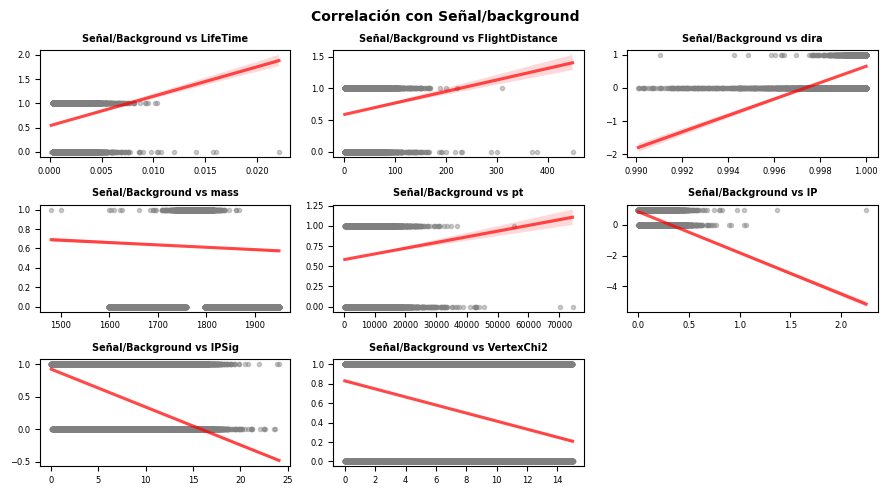

In [4]:
# Variable numérica
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas = subset_tau.select_dtypes(include=['float64', 'int']).columns
columnas = columnas.drop('signal') # objetivo

for i, colum in enumerate(columnas):
    sns.regplot(
        x           = subset_tau[colum],
        y           = subset_tau['signal'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"Señal/Background vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con Señal/background', fontsize = 10, fontweight = "bold");

In [5]:
subset_tau.isnull().any().any()

False

## Selección de datos

1. Objetivo: y
2. Características: x

En este caso queremos separar la señal del background

In [19]:
x = subset_tau['signal']
k = 2  # número de atributos a seleccionar
entrenar = subset_tau.drop(['signal'], axis=1)
columnas = list(entrenar.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(entrenar, x)
atrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(atrib.nonzero()[0])]
atributos

['IPSig', 'production']

In [21]:
modelo = ExtraTreesClassifier() 
erec = RFE(modelo)  
erec = erec.fit(entrenar, x)

In [22]:
atrib = erec.support_
atributos = [columnas[i] for i in list(atrib.nonzero()[0])]
atributos

['LifeTime',
 'dira',
 'IP',
 'IPSig',
 'VertexChi2',
 'isolationa',
 'isolationd',
 'isolatione',
 'isolationf',
 'iso',
 'CDF2',
 'CDF3',
 'ISO_SumBDT',
 'p0_IsoBDT',
 'p1_IsoBDT',
 'p2_IsoBDT',
 'p0_track_Chi2Dof',
 'p1_track_Chi2Dof',
 'p2_track_Chi2Dof',
 'p0_IP',
 'p0_IPSig',
 'SPDhits',
 'production',
 'mass',
 'min_ANNmuon']

In [24]:
# Importancia de atributos.
modelo.fit(entrenar, x)
modelo.feature_importances_[:4]

array([0.00033131, 0.00096686, 0.007578  , 0.00054804, 0.0006005 ,
       0.00780502, 0.03886941, 0.01688059, 0.00056819, 0.00074208,
       0.00079193, 0.00128769, 0.00045797, 0.0008485 , 0.00235668,
       0.00075577, 0.00123092, 0.00924876, 0.00453135, 0.00575676,
       0.00908543, 0.00062568, 0.00327508, 0.00153787, 0.00851371])

In [10]:
#train_cut = train.drop(train[train.min_ANNmuon <= 0.4].index)
train_cut = subset_tau
#y = train_cut.drop(['min_ANNmuon', 'mass', 'production', 'signal', 'id', 'SPDhits'], axis = 1)
y = train_cut.drop(['LifeTime' , 'FlightDistance', 'dira' , 'pt' , 'signal' ] , axis = 1) 
x = train_cut['signal']
pd.set_option('display.max_columns', None)



In [11]:
entrenar_mu = subset_mu.drop(['signal'], axis=1)
modelo_mu = ExtraTreesClassifier() 
erec_mu = RFE(modelo_mu)  
erec_mu = erec_mu.fit(entrenar_mu, x)


In [12]:
atrib_mu = erec_mu.support_
atributos_mu = [columnas[i] for i in list(atrib_mu.nonzero()[0])]
atributos_mu

['mass', 'pt', 'IPSig', 'VertexChi2']

In [13]:
# Importancia de atributos.
modelo_mu.fit(entrenar_mu, x)
modelo_mu.feature_importances_[:4]

array([0.10907381, 0.11076398, 0.1053329 , 0.11226828])